In [70]:
#data transformation
import numpy as np
import pandas as pd 

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#statistics
import statsmodels.formula.api as smf 
from scipy.stats import ttest_ind 
import scipy.stats as stats


In [71]:
np.random.seed(23)

n_samples = 100000
control_mean = 5.3
treatment_mean = control_mean * 0.9  # 10% lower (4.77)
std_dev = 0.7 

# Randomly assigning groups
groups = np.random.choice([0, 1], size=n_samples)

time_to_complete = np.where(
    groups == 0, 
    np.random.normal(control_mean, std_dev, size=n_samples), 
    np.random.normal(treatment_mean, std_dev, size=n_samples)
)

In [72]:
#Assembling into a DataFrame
ab_df = pd.DataFrame({'treated': groups, 'time_to_complete': time_to_complete})

# Verification
print(ab_df.groupby('treated').mean())

         time_to_complete
treated                  
0                5.295016
1                4.771271


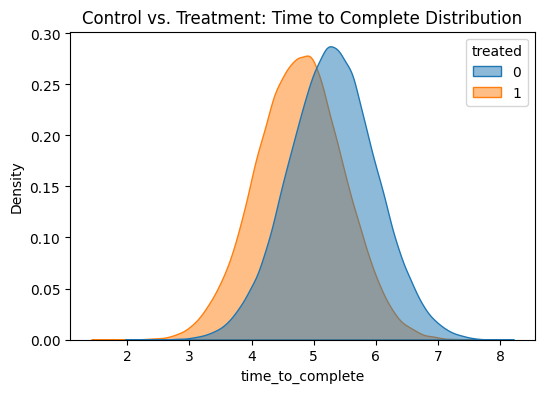

In [73]:
plt.figure(figsize=(6, 4))
sns.kdeplot(data=ab_df, x='time_to_complete', hue='treated', fill=True, alpha=0.5)
plt.title('Control vs. Treatment: Time to Complete Distribution')
plt.show()

## Linear Regression 

In [74]:
formula = 'time_to_complete ~ treated'
model = smf.ols(formula,ab_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       time_to_complete   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                 1.394e+04
Date:                Thu, 26 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:19:52   Log-Likelihood:            -1.0643e+05
No. Observations:              100000   AIC:                         2.129e+05
Df Residuals:                   99998   BIC:                         2.129e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2950      0.003   1693.161      0.0

In [75]:
print("The estimated absolute impact is: {0:.2f} \
      \nThe estimated relative impact is {1:.2f}% \
      \nThe t-statistic is {2:.1f} \
      \nThe p-value is {3:.3f}%".format(
        model.params['treated'],
        100*model.params['treated']/model.params['Intercept'],
        model.tvalues['treated'],
        100*model.pvalues['treated']
))

The estimated absolute impact is: -0.52       
The estimated relative impact is -9.89%       
The t-statistic is -118.1       
The p-value is 0.000%


## 2 sided t-test comparing means

In [76]:

treated_users = ab_df[ab_df['treated']==1]['time_to_complete']
control_users = ab_df[ab_df['treated']==0]['time_to_complete']

t_stat, p_value = ttest_ind(treated_users, control_users)

print(f"t-statistic: {round(t_stat,1)}")
print(f"p-value: {100*round(p_value,3)}%")

t-statistic: -118.1
p-value: 0.0%


## Defining Confidence intervals for 95% confidence level

In [77]:
control = ab_df[ab_df['treated'] == 0]['time_to_complete']
treatment = ab_df[ab_df['treated'] == 1]['time_to_complete']


n_c, n_t = len(control), len(treatment)
mean_c, mean_t = control.mean(), treatment.mean()
std_c, std_t = control.std(), treatment.std()

# Point Estimate and Standard Error
diff = mean_t - mean_c
se = np.sqrt((std_c**2 / n_c) + (std_t**2 / n_t))

# 95% CI Calculation (using 1.96 for a large sample size)
ci_lower = diff - 1.96 * se
ci_upper = diff + 1.96 * se

print(f"Observed Difference in seconds: {abs(diff) * (-60):.1f}")
print(f"95% Confidence Interval in seconds: [{abs(ci_lower)*(-60):.1f}, {abs(ci_upper)* (-60):.1f}]")

Observed Difference in seconds: -31.4
95% Confidence Interval in seconds: [-31.9, -30.9]


## Conclusion
We simulated data for an experiment where the true effect of the treatment decrease Time to action by a relative 10% from a baseline Time to action of 5.3 min to 4.8 min. The experiment successfully detected the targeted 31.4-second improvement in completion time with a p-value near zero and a tight confidence interval [-31.9, -30.9].